In [1]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import zipfile
import io
import pandas as pd
import math
from IPython.display import display
from collections import defaultdict

zipped_data_path = "../data/clean_data/class-competition.zip"

dataframes = defaultdict(pd.DataFrame)
with zipfile.ZipFile(zipped_data_path, "r") as zip:
    for filename in zip.namelist():
        if filename.endswith(".csv"):
            with zip.open(filename) as f:
                dataframes.update({ filename : pd.read_csv(io.TextIOWrapper(f)) })

                # Lets take a look at the files
                print(f"FILE: {filename}")
                # If you want to see file info uncomment this:
                # display(dataframes[filename].info())
                # display(dataframes[filename].head())

train_data = dataframes["train.csv"]
test_data  = dataframes["test_public.csv"]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

FILE: train.csv
FILE: test_public.csv
cuda:0


In [31]:
from sklearn.model_selection import train_test_split

ALL_FEATURES = ['TRIP_ID', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'MISSING_DATA',
 'POLYLINE', 'CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C', 'YEAR_2013', 'YEAR_2014',
 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12',
 'DAY_OF_WEEK_0', 'DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3',
 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'HOUR_0', 'HOUR_1',
 'HOUR_2', 'HOUR_3', 'HOUR_4', 'HOUR_5', 'HOUR_6', 'HOUR_7', 'HOUR_8',
 'HOUR_9', 'HOUR_10', 'HOUR_11', 'HOUR_12', 'HOUR_13', 'HOUR_14',
 'HOUR_15', 'HOUR_16', 'HOUR_17', 'HOUR_18', 'HOUR_19', 'HOUR_20',
 'HOUR_21', 'HOUR_22', 'HOUR_23']

# We could totally change this. Utilization of these just probably requires further preprocessing.
ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION = ['TRIP_ID', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'POLYLINE']

train_data_sample = train_data.sample(frac=0.2, random_state=420) # frac is used to control percentage of train data used
X = train_data_sample.drop("TRAVEL_TIME", axis=1)
X = X.loc[:, ~X.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]
y = train_data_sample["TRAVEL_TIME"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

test_features = test_data.loc[:, ~test_data.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]

In [32]:
from torch.utils.data import DataLoader, Dataset
from cnn_utils import TaxiDataset
    
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_test_public = test_features.astype(float) # This is what we can predict on

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)
X_test_public_tensor = torch.tensor(X_test_public.values, dtype=torch.float32)

train_dataset = TaxiDataset(X_train_tensor, y_train_tensor)
test_dataset = TaxiDataset(X_test_tensor, y_test_tensor)
test_public_dataset = TaxiDataset(X_test_public_tensor)

batch_size = 32

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloader_pred = DataLoader(test_public_dataset, batch_size=batch_size)

In [33]:
class CNN(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 4, 128),
            nn.Sigmoid(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return x

In [34]:
from cnn_utils import num_parameters

cnn = CNN()
if torch.cuda.is_available():
    cnn.cuda()
 
num_parameters(cnn)

40865

In [35]:
from cnn_utils import pipeline
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, weight_decay=1e-2)

train_losses, test_loss, predictions = pipeline(cnn, optimizer, dataloader_train=dataloader_train, 
                                                dataloader_test=dataloader_test, dataloader_pred=dataloader_pred,
                        			device=device, criterion=criterion, epochs=30)

100%|██████████| 50/50 [17:33<00:00, 21.06s/it]


Training process has finished.


In [36]:
print(f"Final Train Loss: {train_losses[-1]}")
print(f"Test Loss: {test_loss}")

Final Train Loss: 694.8251112177861
Test Loss: 693.2115259636449


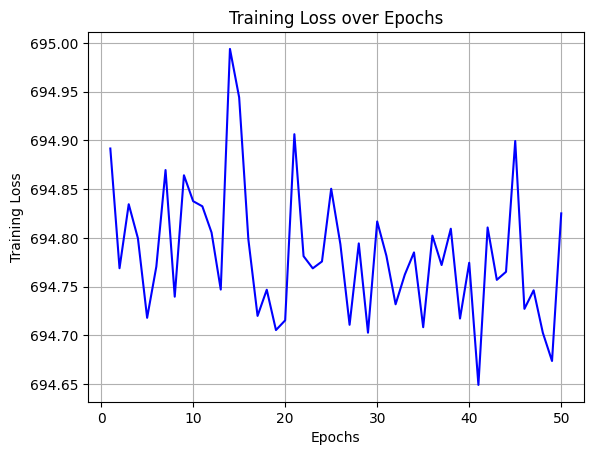

In [37]:
import matplotlib.pyplot as plt

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot the training loss
plt.plot(epochs, train_losses, 'b-')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [39]:
from cnn_utils import test_prediction_to_csv

test_prediction_to_csv(predictions, "predicting_cnn.csv", test_data)